# Investigating Gapminder Data - Income and Life Expectancy

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#data_munging">Data Munging</a></li>    
<li><a href="#eda">Exploratory Data Analysis</a></li>
    <ul><li><a href="#q1">Q1 - Does an increase in income correlate to an increase in life expectancy?</a></li>
    <li><a href="#q2">Q2 - Does a country's region have an impact on the correlation of income and life expectancy?</a></li>
    <li><a href="#q3">Q3 - Does a country's Human Development Index score have an impact on the correlation of income and life expectancy?</a></li></ul>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

This data analysis is going to use data from Gapminder, a Swedish "fact tank" that consolidates world data and makes it readily available to use and understand.

This analysis will be looking at income and life expectancy, to see if there is any correlation here. After cleaning and wrangling the data, we will investigate the resulting dataset to see what correlations we can find.

<a id='wrangling'></a>
## Data Wrangling

* Our first step is to import all of the packages that we will use for this analysis
    * We import matplotlib's pyplot module as plt
    * We import numpy as np - we could import numpy indirectly because it is imported with pandas, but it wouldn't have the np alias
    * We import pandas as pd
    * We import seaborn - a visualization module built on matplotlib - as sns
    * We also use the magic command %matplotlib inline to show visualizations inline
    * We are also going to import statsmodels.api as sm - This will be used for some statistical analysis later on

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib
import numpy as np

import pandas as pd
import seaborn as sns
import statsmodels.api as sm

* Next we will bring in all of our data
* This data is from Gapminder, and we are focusing on the correlation of income and life expectancy.
* The data sets we are bringing in are:
    * income - GDP per capita, constant PPP (purchasing power parity) dollars
        * The link for this is __[here](http://gapm.io/dgdppc)__
    * life_expect - life expectancy at birth
        * The link for this is __[here](http://gapm.io/ilex)__
    * hdi - Human Development Index
        * The link for this is __[here](http://hdrstats.undp.org/en/indicators/103106.html)__
        * Note - the link is currently giving me a DNS error - I am unsure if the link is dead or currently down
    * geo - This is Gapminder's geography dataset - it adds additional dimensions to the country, such as region, world back income level, etc
        * The link for this is __[here](https://www.gapminder.org/data/geo/)__
        * Note - this is the only dataset that we have modified before loading - the "list-of-countries-etc" sheet in the Excel file was saved as a csv for easy importing into this notebook

In [2]:
income = pd.read_csv(r"C:\Users\jcsmi329\Documents\Homework\Udacity\Projects\Investigate a Dataset\income_per_person_gdppercapita_ppp_inflation_adjusted.csv")
life_expect = pd.read_csv(r"C:\Users\jcsmi329\Documents\Homework\Udacity\Projects\Investigate a Dataset\life_expectancy_years.csv")
hdi = pd.read_csv(r"C:\Users\jcsmi329\Documents\Homework\Udacity\Projects\Investigate a Dataset\hdi_human_development_index.csv")
geo = pd.read_csv(r"C:\Users\jcsmi329\Documents\Homework\Udacity\Projects\Investigate a Dataset\gapminder_geo.csv")

<a id='data_munging'></a>
### Data munging

* We need to get our data from multiple dataframes into one dataframe that has columns for each indicator value

* Our geography dataset has columns that we will not be using, so we are going to drop those
* This will leave the following columns
    * four_regions, eight_regions, and World bank income group 2017
    * We rename the world bank income group to something easier to work with - wb_income_2017

In [3]:
geo.drop(['geo','six_regions','Latitude','Longitude','UN member since','World bank region','members_oecd_g77'], axis = 1, inplace = True)
geo.rename(index = str, columns = {'World bank income group 2017':'wb_income_2017'}, inplace = True)

* The columns in these datasets are years, so we need to check the ranges of the years to see where they overlap
* There are many ways to do this, but we will use iloc to print out a list of columns  by index location
* This was recommended by __[this stackoverflow post](https://stackoverflow.com/questions/42632029/how-to-use-python-to-select-first-x-columns-and-last-y-columns)__

In [4]:
print(income.iloc[0:0,[0,1]+[-1]],'\n',
hdi.iloc[0:0,[0,1]+[-1]],'\n',
life_expect.iloc[0:0,[0,1]+[-1]])

Empty DataFrame
Columns: [country, 1800, 2040]
Index: [] 
 Empty DataFrame
Columns: [country, 1990, 2015]
Index: [] 
 Empty DataFrame
Columns: [country, 1800, 2018]
Index: []


* The indicator data sets contain data for many years, but we are going to focus on only the most recent year included in all datasets
* To do this, we create a list that contains the columns we want to keep, and we use the filter function on the dataframes to filter to just these columns
* Since we saw above that 2015 was the latest year that was in all of the datasets, we will use filter to just the country and the year 2015

In [5]:
col_list = ['country','2015']

income = income.filter(col_list)
hdi = hdi.filter(col_list)
life_expect = life_expect.filter(col_list)

* We set the indexes of the datasets, as they are currently just numbered

In [6]:
income.set_index('country', inplace = True)
hdi.set_index('country', inplace = True)
life_expect.set_index('country', inplace = True)
geo = geo.set_index('name', True)
geo.index.names = ['country']

* We need to move the year down to be values in a column instead of being a header, for all of the indicator datasets
* We also need to rename the remaining column to match the indicator
* After trial and error, the below will do all of this in one line for each 
* If this were to be production level code, we would likely want to wrap this in a function call, but that is overkill to replace just three lines of code

In [7]:
income = income.stack(0).reset_index(level = 1).rename(index = str, columns = {'level_1':'year',0:'income'})
hdi = hdi.stack(0).reset_index(level = 1).rename(index = str, columns = {'level_1':'year',0:'hdi'})
life_expect = life_expect.stack(0).reset_index(level = 1).rename(index = str, columns = {'level_1':'year',0:'life_expect'})

* We now need to join our dataframes into one dataframe that contains all of the indicator values
* To do this we will use the pandas merge function, and we will join on both the column year and the index, as the index is shared by all dataframes
* We use the inner join to ensure that we only include data that is included in all datasets

In [8]:
df = pd.merge(income, hdi, how = 'inner', on = 'year',left_index = True, right_index = True, sort = True)
df = pd.merge(df, life_expect, how = 'inner', on = 'year',left_index = True, right_index = True, sort = True)
df = pd.merge(df, geo, how = 'inner', left_index = True, right_index = True, sort = True)

* We sort the values, because the labels on the plots will correspond to how the values are sorted

In [9]:
df.sort_values(['four_regions','eight_regions'], inplace = True)

* We drop NaNs because we need to be able to plot all values
* We round hdi and life expectancy to allow them to be used more easily for hue and other categorical uses

In [10]:
df.dropna(inplace = True)

df.hdi = round(df.hdi, 1)

df.life_expect = round(df.life_expect,0)

* We add a column that converts the world bank income value to a number
* Hopefully this will be useful for categorizing income when we do not want to use the actual income figures, we will have to check this
* We are going to convert the regions into category codes as well - this may or may not be useful later

In [11]:
#creating ordered category codes http://benalexkeen.com/mapping-categorical-data-in-pandas/

ordered_incomes = ['Low income', 'Lower middle income', 'Upper middle income', 'High income']

df['wb_code'] = df.wb_income_2017.astype("category",
  ordered=True,
  categories=ordered_incomes
).cat.codes

C:\Users\jcsmi329\AppData\Local\Continuum\miniconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  import sys


In [12]:
#category codes http://benalexkeen.com/mapping-categorical-data-in-pandas/

df['four_regions_code'] = df.four_regions.astype("category").cat.codes

df['eight_regions_code'] = df.eight_regions.astype("category").cat.codes

##### Let's use the describe function to see view some statistics about our dataset as a whole

* We can see that all of the columns have a count of 184, which is good - all of our records have data for all of the indicators
* Another thing that jumps out is the standard deviation of income - 19,136; this is a very large standard deviation and it seems like there are going to be some pretty large outliers in this column
* Another thing to notice is that hdi is between 0 and 1 - this makes sense given the way HDI is calculated as shown below
    * Note - We will see some correlation between HDI and income as income is included in the HDI calculation. However, the HDi includes two other variables, so HDI is still valid to use to compare with income and life expectancy

> $HDI = (I_{Health} * I_{Education} * I_{Income})^1/3$ <br><br>
> More information __[here](http://hdr.undp.org/en/content/human-development-index-hdi)__

In [13]:
df.describe()

,income,hdi,life_expect,wb_code,four_regions_code,eight_regions_code
count,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000
mean,17427.918478,0.692935,72.059783,1.679348,1.483696,3.538043
std,19136.086742,0.155778,7.586421,1.045630,1.149842,2.204979
min,626.000000,0.400000,50.000000,0.000000,0.000000,0.000000
25%,3290.000000,0.600000,66.000000,1.000000,0.000000,1.000000
50%,10950.000000,0.700000,73.500000,2.000000,2.000000,4.000000
75%,24275.000000,0.800000,78.000000,3.000000,2.000000,5.000000
max,120000.000000,0.900000,84.000000,3.000000,3.000000,7.000000


##### Let's also look at the correlation between the different measures, using the corr function

* From this, we can see that HDI and income are pretty highly correlated, as we expected
* It is also interesting to note that wb_code and income are correlated, at a pretty high value, so we can use wb_code to categorize income without much concern of inaccuracies
    * Note - it is important to keep in mind that the World Bank Income groups are based on GNI for an economy, and our income measure is based on GDP
    * More information on the World Bank Income groups can be found __[here](https://datahelpdesk.worldbank.org/knowledgebase/articles/906519-world-bank-country-and-lending-groups)__
* Life expectancy and income do seem to be positively correlated, which is not unexpected
* Four regions and eight regions are highly correlated, which makes sense
* It is interesting to note that both region categories are correlated with income, life expectancy, and HDI
    * We cannot say if the correlation is positive or negative, as the numbers in these region columns are randomly applied
    * But this is a hint that we should look into how region affects each of these measures

In [14]:
df.corr()

,income,hdi,life_expect,wb_code,four_regions_code,eight_regions_code
income,1.000000,0.733463,0.659292,0.761711,0.482817,0.492985
hdi,0.733463,1.000000,0.888144,0.908583,0.702548,0.677708
life_expect,0.659292,0.888144,1.000000,0.806335,0.646277,0.609590
wb_code,0.761711,0.908583,0.806335,1.000000,0.597839,0.584809
four_regions_code,0.482817,0.702548,0.646277,0.597839,1.000000,0.976593
eight_regions_code,0.492985,0.677708,0.609590,0.584809,0.976593,1.000000


<a id='eda'></a>
## Exploratory Data Analysis

Now that we have a decent idea about how are data looks and how it is correlated, we will dive into the research questions


<a id='q1'></a>
#### Question 1 - Does an increase in income correlate to an increase in life expectancy?

* Our first step is create a swarm plot that compares the WB income groups to the life expectancy
* We can see from this that there is clearly a strong relationship between these income groups and life expectancy
* As the wb_code increases (0 is lowest, 3 is highest) the life expectancy also goes up

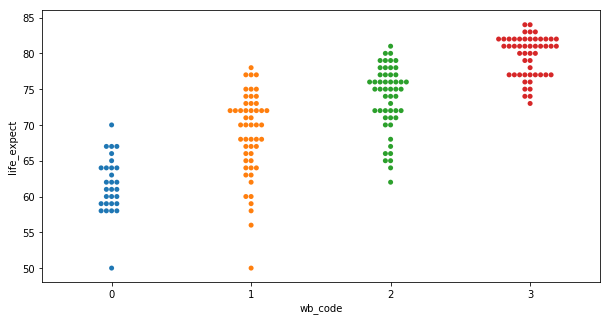

In [15]:
f, ax = plt.subplots(figsize = (10,5))

sns.swarmplot(x="wb_code", y="life_expect", data=df)

* Since we already can see a correlation, let's try plotting a linear regression and see what we get
* We will use the income measure instead of the wb_code since there is more variation in the income
* We will use a jointplot in Seaborn, this allows us to see both the linear regression line as well as the histograms of the measures on the top and right side
* From this we can see even more clearly that life expectancy and income are positively correlated

C:\Users\jcsmi329\AppData\Local\Continuum\miniconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


(40, 90)

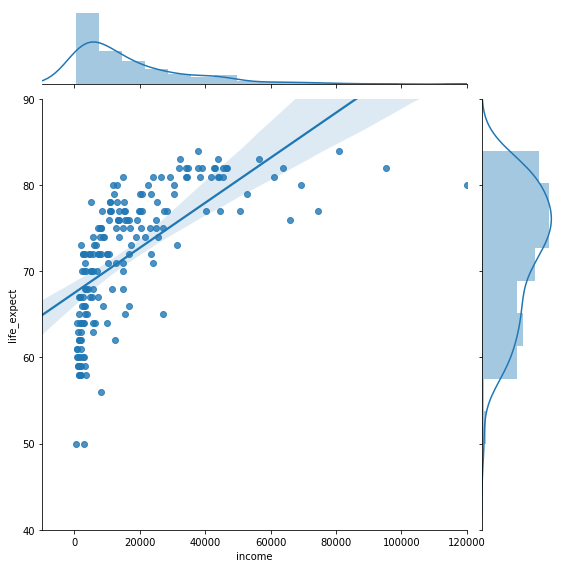

In [16]:
sns.jointplot(x="income", y="life_expect", data=df, kind="reg", height = 8)

plt.xlim(-10000,120000)
plt.ylim(40,90)

* Below we have fit these two variables to a linear regression model and printed the summary
    * This is similar to what you would see if you ran a linear regression in Excel's Data Analysis Toolpak
* We can see that the R-squared value is .521 - this tells us that a little over half of the variation of life expectancy can be explained by the income
* Another statistic to note is the coefficient for income - .0020 - this means that as the income increases by 1, the life expectancy value increases by .0020

##### _From this, we can confirm that there is a positive correlation between income and life expectancy_

However, it must be stated that this does not mean there is a causal relationship, and we are not looking at all of the variables that can affect life expectancy. Since the income only explains half of life expectancy, it is obvious that there is more to this equation

In [17]:
## Based on code found here https://towardsdatascience.com/simple-and-multiple-linear-regression-in-python-c928425168f9

X = df["income"]
y = df["life_expect"]

# Note the difference in argument order
model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            life_expect   R-squared:                       0.521
Model:                            OLS   Adj. R-squared:                  0.518
Method:                 Least Squares   F-statistic:                     198.7
Date:                Sun, 27 Jan 2019   Prob (F-statistic):           4.99e-31
Time:                        15:25:34   Log-Likelihood:                -981.52
No. Observations:                 184   AIC:                             1965.
Df Residuals:                     183   BIC:                             1968.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
income         0.0020      0.000     14.096      0.000       0.002       0.002
==============================================================================
Omnibus:                      117.664   Durbin-Watson:                   0.706
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              705.420
Skew:                          -2.484   Prob(JB):                    6.61e-154
Kurtosis:                      11.206   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<a id='q2'></a>
#### Question 2 - Does a country's region have an impact on the correlation of income and life expectancy?

* Again we use a swarm plot to compare income (wb_code) to life expectancy
* This time, we will use the hue parameter to color the dots based on the hues of the four regions value
* We can see that Africa (blue) comprises most of the first wb_code, but we really can't see much more affect of the regions beyond that
* Let's try another way of looking at this

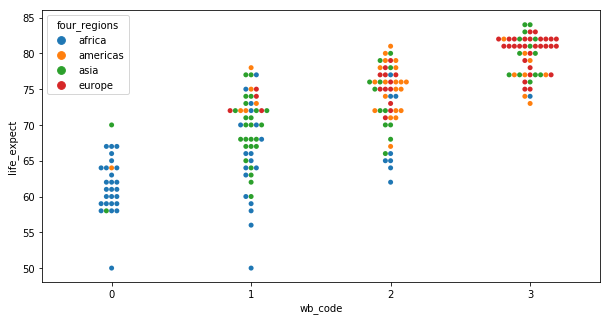

In [18]:
f, ax = plt.subplots(figsize = (10,5))

sns.swarmplot(x="wb_code", y="life_expect", data=df, hue = "four_regions")

* To compare regions side by side, we will use the Seaborn FacetGrid to plot out the linear regression of income to life expectancy, for each region independently
* From this, it looks like the linear regression line for Africa is the most positively correlated, although the income increase and life expectancy increase both stop much sooner than in the other plots
* Let's see if we can get some statistics to provide more clarity

(-5000, 100000)

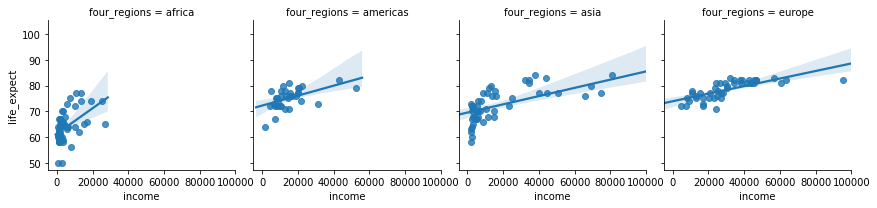

In [19]:
g = sns.FacetGrid(df, col="four_regions")
g.map(sns.regplot, "income", "life_expect")
g.add_legend()

plt.xlim(-5000, 100000)

* Before we check our linear regression model, we have to change the dataframe slightly
* In order to have each region be included as a separate variable in the model, we need to create a column for each region that will be either 1 or 0
* To do this we use the get_dummies method and join this resulting dataset to the df dataset that we've been using

In [20]:
df_dummies = df.four_regions.str.get_dummies()

df_dummies = pd.merge(df, df_dummies, left_index=True, right_index=True)

* We can see that the R-squared value is .675 - this is higher than the R-squared value of just income by itself which tells us that the region and income combined have a higher correlation with life expectancy
* The coefficients need to be read differently now that we are passing in multiple variables
    * The coefficient of income is now only .0002 - this tells us that regardless of the region, income increasing by 1 will increase life expectancy by .0002
        * This makes sense, as we can tell that life expectancy increases more in some regions than others
    * The coefficients of the regions (rounded to whole numbers for simplicity here) are 63, 72, 73, and 69 for Africa, Americas, Europe, and Asia respectively
    * This explains what we saw in the above plots - in the Americas and Europe, income more positively correlates to life expectancy. However in Africa and Asia, it isn't as simple - more income is associated with a higher life expectancy, but not as much life expectancy

##### _From this, we can confirm that the region of the world that a country is in does have an impact on the correlation of it's citizens income and life expectancy_

The same disclaimer as above applies, we cannot be certain why this affect occurs, and there is likely variables that we are missing here

In [21]:
## Based on code found here https://towardsdatascience.com/simple-and-multiple-linear-regression-in-python-c928425168f9

X = df_dummies[["income", "africa","americas","europe","asia"]]
y = df_dummies["life_expect"]

# Note the difference in argument order
model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            life_expect   R-squared:                       0.675
Model:                            OLS   Adj. R-squared:                  0.667
Method:                 Least Squares   F-statistic:                     92.80
Date:                Sun, 27 Jan 2019   Prob (F-statistic):           1.39e-42
Time:                        15:25:35   Log-Likelihood:                -530.13
No. Observations:                 184   AIC:                             1070.
Df Residuals:                     179   BIC:                             1086.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
income         0.0002   1.94e-05      8.852      0.000       0.000       0.000
africa        63.1000      0.610    103.460      0.000      61.896      64.303
americas      72.5817      0.807     89.962      0.000      70.990      74.174
europe        73.1762      0.881     83.034      0.000      71.437      74.915
asia          69.3148      0.717     96.706      0.000      67.900      70.729
==============================================================================
Omnibus:                        4.318   Durbin-Watson:                   1.868
Prob(Omnibus):                  0.115   Jarque-Bera (JB):                5.227
Skew:                          -0.114   Prob(JB):                       0.0733
Kurtosis:                       3.794   Cond. No.                     8.14e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.14e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<a id='q3'></a>
#### Question 3 -  Does a country's Human Development Index score have an impact on the correlation of income and life expectancy?

* The first thing we will do to investigate if the HDI score has an affect on the correlatoin of income and life expectancy is attempt to plot this in a swarm plot, similarly to how we did this previously
* As we can see below, we are using the hue to show the HDI score, and we are showing the relationship between World Back income groups and life expectancy
* There doesn't seem to be any real trend here of HDI score affecting the relationship that we have already seen between income and life expectancy

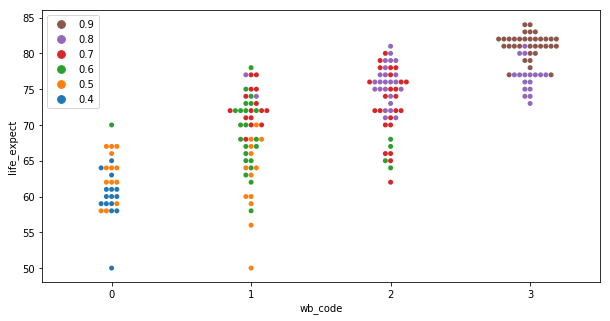

In [22]:
## How to order lables from here:
## https://stackoverflow.com/questions/22263807/how-is-order-of-items-in-matplotlib-legend-determined

f, ax = plt.subplots(figsize = (10,5))

sns.swarmplot(x="wb_code", y="life_expect", data=df, hue = "hdi")

handles, labels = ax.get_legend_handles_labels()

labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0], reverse = True))

ax.legend(handles, labels)

* We will create a new dataframe that creates dummy values for the HDI score so that we can check the linear regression stats on this as well
* We have to take an extra step to convert the numeric type to a string so we can create dummy values

In [23]:
df_dummies_2 = df.copy()

df_dummies_2['hdi'] = df_dummies_2['hdi'].apply(str)

df_dummies_2 = df_dummies_2.hdi.str.get_dummies()

df_dummies_2 = pd.merge(df, df_dummies_2, left_index=True, right_index=True)

* The below linear regression model seems to show that as the HDI score increases, the life expectancy increases
* We saw the same type of relationship with income, where income increasing had a correlation with life expectancy increasing
* It doesn't seem like there is any obvious affect of HDI on the correlation between life expectancy and income
* In fact, in retrospect, this question seems almost redundant, as income is part of the HDI score

##### _From this, we can not confirm that the HDI score of a country has any impact on the correlation of it's citizens income and life expectancy_

In [24]:
## Based on code found here https://towardsdatascience.com/simple-and-multiple-linear-regression-in-python-c928425168f9

X = df_dummies_2[["0.4","0.5","0.6","0.7","0.8","0.9"]]
y = df_dummies_2["life_expect"]

# Note the difference in argument order
model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            life_expect   R-squared:                       0.794
Model:                            OLS   Adj. R-squared:                  0.788
Method:                 Least Squares   F-statistic:                     136.9
Date:                Sun, 27 Jan 2019   Prob (F-statistic):           4.58e-59
Time:                        15:25:36   Log-Likelihood:                -488.24
No. Observations:                 184   AIC:                             988.5
Df Residuals:                     178   BIC:                             1008.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0.4           59.8667      0.902     66.355      0.000      58.086      61.647
0.5           62.8846      0.685     91.765      0.000      61.532      64.237
0.6           68.4444      0.672    101.780      0.000      67.117      69.771
0.7           72.8974      0.560    130.283      0.000      71.793      74.002
0.8           76.1395      0.533    142.885      0.000      75.088      77.191
0.9           81.2059      0.599    135.510      0.000      80.023      82.388
==============================================================================
Omnibus:                       17.448   Durbin-Watson:                   1.935
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               24.338
Skew:                          -0.582   Prob(JB):                     5.19e-06
Kurtosis:                       4.348   Cond. No.                         1.69
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<a id='conclusions'></a>
## Conclusions

We have now investigated the relationships between income, region, and HDI score and how these impact life expectancy. We used data from Gapminder to plot out the relationships between income and life expectancy, as well as income and life expectancy by region. We also tried to find if there was a country's HDI score had any affect on the link between income and life expectancy.

We found that there is a positive correlation between income and life expectancy. As income increases, so does life expectancy. We also found that the amount of correlation was different across the four regions of the world. The Americas and Europe had a higher correlation than Africa and Asia. This makes sense, as there are more developing countries in Africa and Asia. Futures investigations may want to break down these four regions into smaller regions to see if this has any impact on the correlation.

We attempted to see if HDI score had an affect on income and life expectancy. These results were inconclusive, but it does not seem that there is any affect due to HDI. This makes sense, as income is one of the three factors that go into the HDI score. In retrospect, we should have used another measure instead of HDI.

We did use linear regression models to determine R-squared values and coefficients of variables. However, this is the extent of our statistical analysis. We did not complete any statistical tests, and we certainly cannot say that there is any causation, only that there is correlation.

*Note - in general the plots in this notebook do not have sources attributed to them as to where I learned the specific technique or code. I completed two Pluralsight courses "Visualizing Statistical Data using Seaborn" and "Building Data Visualizations Using Matpotlib" prior to completing this assignment, to gain more understanding in plotting data in Python. Unless otherwise specified, the techniques I used came from these courses.*